In [ ]:
import pandas as pd

final_df = pd.read_csv("final_model_dataset.csv")
final_df.head()


,HotelID,Month,OccupiedRoomNights,MonthStart,DaysInMonth,TotalRooms,OccupancyRate,ADR,CancellationRate,MeanSentiment,ReviewCount
0,1,2022-01,21,2022-01-01,31,122,0.222105,243.704286,0.000000,0.279233,3.0
1,1,2022-02,18,2022-02-01,28,122,0.210773,215.478333,0.333333,0.056520,5.0
2,1,2022-03,3,2022-03-01,31,122,0.031729,219.232500,0.500000,0.390000,3.0
3,1,2022-04,19,2022-04-01,30,122,0.207650,213.618571,0.428571,0.413600,2.0
4,1,2022-05,9,2022-05-01,31,122,0.095188,213.473333,0.333333,-0.509500,2.0


In [ ]:
# Persist dataset state to prevent loss during feature engineering
final_df.to_csv("final_model_dataset.csv", index=False)


In [ ]:
# Convert Month to datetime to enforce proper temporal ordering
final_df["Month"] = pd.to_datetime(final_df["Month"])


In [ ]:
# Sort records by hotel and time to ensure accurate lag computation
final_df = final_df.sort_values(["HotelID", "Month"])


In [ ]:
# Create a lagged sentiment feature to capture delayed guest behaviour
final_df["Sentiment_Lag1"] = (
    final_df
    .groupby("HotelID")["MeanSentiment"]
    .shift(1)
)


In [ ]:
# Preview lag alignment for validation
final_df[
    ["HotelID", "Month", "MeanSentiment", "Sentiment_Lag1"]
].head(10)


,HotelID,Month,MeanSentiment,Sentiment_Lag1
0,1,2022-01-01,0.279233,NaN
1,1,2022-02-01,0.056520,0.279233
2,1,2022-03-01,0.390000,0.056520
3,1,2022-04-01,0.413600,0.390000
4,1,2022-05-01,-0.509500,0.413600
5,1,2022-06-01,-0.177775,-0.509500
6,1,2022-07-01,-0.270650,-0.177775
7,1,2022-08-01,0.585900,-0.270650
8,1,2022-09-01,0.401900,0.585900
9,1,2022-10-01,0.448250,0.401900


In [ ]:
# Replace initial lag nulls with zero to maintain temporal continuity
final_df["Sentiment_Lag1"] = final_df["Sentiment_Lag1"].fillna(0)


In [ ]:
# Validate distribution of the engineered lag feature
final_df["Sentiment_Lag1"].describe()


,Sentiment_Lag1
count,952.000000
mean,0.237753
std,0.270583
min,-0.542300
25%,0.000000
50%,0.260250
75%,0.445412
max,0.762000


In [ ]:
# Export dataset with lagged sentiment for analytical use
final_df.to_csv("final_model_dataset_lagged.csv", index=False)


In [ ]:
# Load lagged dataset for exploratory validation
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("final_model_dataset_lagged.csv")

# Safety check
df[["OccupancyRate", "MeanSentiment", "Sentiment_Lag1"]].head()


,OccupancyRate,MeanSentiment,Sentiment_Lag1
0,0.222105,0.279233,0.000000
1,0.210773,0.056520,0.279233
2,0.031729,0.390000,0.056520
3,0.207650,0.413600,0.390000
4,0.095188,-0.509500,0.413600


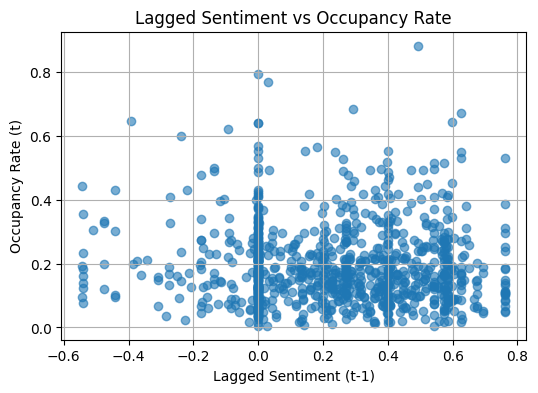

In [ ]:
# Visualise relationship between lagged sentiment and occupancy
plt.figure(figsize=(6,4))
plt.scatter(df["Sentiment_Lag1"], df["OccupancyRate"], alpha=0.6)
plt.xlabel("Lagged Sentiment (t-1)")
plt.ylabel("Occupancy Rate (t)")
plt.title("Lagged Sentiment vs Occupancy Rate")
plt.grid(True)
plt.show()


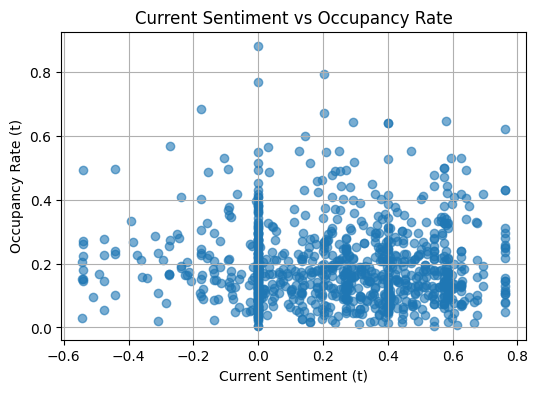

In [ ]:
# Compare contemporaneous sentiment with occupancy performance
plt.figure(figsize=(6,4))
plt.scatter(df["MeanSentiment"], df["OccupancyRate"], alpha=0.6)
plt.xlabel("Current Sentiment (t)")
plt.ylabel("Occupancy Rate (t)")
plt.title("Current Sentiment vs Occupancy Rate")
plt.grid(True)
plt.show()


In [ ]:
# Quantify linear relationships to assess predictive relevance
corr_current = df["MeanSentiment"].corr(df["OccupancyRate"])
corr_lagged = df["Sentiment_Lag1"].corr(df["OccupancyRate"])

corr_current, corr_lagged


(np.float64(-0.02888523772616025), np.float64(-0.033312003326520116))

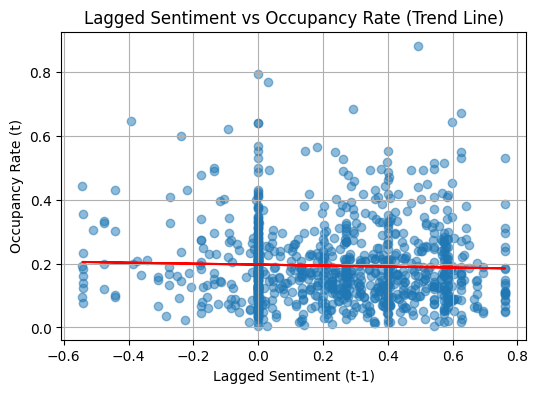

In [ ]:
# Overlay trend line to evaluate directional influence
import numpy as np

x = df["Sentiment_Lag1"]
y = df["OccupancyRate"]

m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, m*x + b, color="red")
plt.xlabel("Lagged Sentiment (t-1)")
plt.ylabel("Occupancy Rate (t)")
plt.title("Lagged Sentiment vs Occupancy Rate (Trend Line)")
plt.grid(True)
plt.show()


In [ ]:
# Evaluate correlation under minimum review thresholds to reduce noise
df[df["ReviewCount"] >= 3][["Sentiment_Lag1", "OccupancyRate"]].corr()


,Sentiment_Lag1,OccupancyRate
Sentiment_Lag1,1.000000,-0.097487
OccupancyRate,-0.097487,1.000000
